In [1]:
using BSON
using Flux
using HDF5
using Plots

In [2]:
include("ActiveLearning.jl")
include("DataSets.jl")
using .ActiveLearning
using .DataSets

In [3]:
X_mnist_train, y_mnist_train, X_mnist_test, y_mnist_test = prepare_mnist(get_mnist("data/mnist"))
size(X_mnist_train), size(X_mnist_test)

((32, 32, 1, 60000), (32, 32, 1, 10000))

In [7]:
file = "data/human_labeller.hdf5"
h5open(file, "w") do datafile
    write(datafile, "X", X_mnist_train)
    write(datafile, "y", y_mnist_train)
end

function human_labeller_wrap(index_query, prob_query, round)
    human_labeller(index_query, prob_query, round, y_mnist_train, file)
end 

rounds_human, accuracies_human = simulate_al(
    entropy_sampling, human_labeller_wrap,
    BSON.load("lenet.bson")[:model],
    X_mnist_train, y_mnist_train,
    X_mnist_test, y_mnist_test,
    n_query=100)

stdin>  index_label_1


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 10
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 1
│   accuracy_round = 0.6951
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_2


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 20
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 2
│   accuracy_round = 0.7834
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_3


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 30
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 3
│   accuracy_round = 0.7916
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_4


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 40
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 4
│   accuracy_round = 0.8709
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_5


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 50
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 5
│   accuracy_round = 0.8826
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_6


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 60
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 6
│   accuracy_round = 0.886
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_7


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 70
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 7
│   accuracy_round = 0.9171
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_8


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 80
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 8
│   accuracy_round = 0.916
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_9


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 90
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 9
│   accuracy_round = 0.9296
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_10


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 100
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 10
│   accuracy_round = 0.9443
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_11


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 110
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 11
│   accuracy_round = 0.9435
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_12


┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 120
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 12
│   accuracy_round = 0.9535
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_13


┌ Info: performance
│   round = 13
│   accuracy_round = 0.9548
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_14


┌ Info: performance
│   round = 14
│   accuracy_round = 0.9613
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_15


┌ Info: performance
│   round = 15
│   accuracy_round = 0.9576
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_16


┌ Info: performance
│   round = 16
│   accuracy_round = 0.9618
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_17


┌ Info: performance
│   round = 17
│   accuracy_round = 0.9667
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_18


┌ Info: performance
│   round = 18
│   accuracy_round = 0.9715
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_19


┌ Info: performance
│   round = 19
│   accuracy_round = 0.972
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_20


┌ Info: performance
│   round = 20
│   accuracy_round = 0.9726
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_21


┌ Info: performance
│   round = 21
│   accuracy_round = 0.9736
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_22


┌ Info: performance
│   round = 22
│   accuracy_round = 0.973
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_23


┌ Info: performance
│   round = 23
│   accuracy_round = 0.9766
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_24


┌ Info: performance
│   round = 24
│   accuracy_round = 0.9753
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_25


┌ Info: performance
│   round = 25
│   accuracy_round = 0.9762
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_26


┌ Info: performance
│   round = 26
│   accuracy_round = 0.9692
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_27


┌ Info: performance
│   round = 27
│   accuracy_round = 0.9774
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_27


┌ Info: performance
│   round = 28
│   accuracy_round = 0.98
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_28


┌ Info: performance
│   round = 29
│   accuracy_round = 0.9768
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


stdin>  index_label_29


┌ Info: performance
│   round = 30
│   accuracy_round = 0.9788
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73


(0:30, [0.6352, 0.6951, 0.7834, 0.7916, 0.8709, 0.8826, 0.886, 0.9171, 0.916, 0.9296  …  0.9736, 0.973, 0.9766, 0.9753, 0.9762, 0.9692, 0.9774, 0.98, 0.9768, 0.9788])

In [9]:
rounds_random, accuracies_random = simulate_al(
    random_sampling, oracle,
    BSON.load("lenet.bson")[:model],
    X_mnist_train, y_mnist_train,
    X_mnist_test, y_mnist_test)

┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 10
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 1
│   accuracy_round = 0.674
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 20
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 2
│   accuracy_round = 0.7597
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 30
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 3
│   accuracy_round = 0.8293
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73
┌ Warning: Number of observations less than batchsize, d

(0:30, [0.6352, 0.674, 0.7597, 0.8293, 0.8641, 0.8819, 0.8962, 0.9104, 0.9194, 0.9247  …  0.9448, 0.9482, 0.941, 0.9492, 0.9519, 0.9532, 0.947, 0.9411, 0.9557, 0.9549])

In [10]:
rounds_entropy, accuracies_entropy = simulate_al(
    entropy_sampling, oracle,
    BSON.load("lenet.bson")[:model],
    X_mnist_train, y_mnist_train,
    X_mnist_test, y_mnist_test)

┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 10
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 1
│   accuracy_round = 0.6964
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 20
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 2
│   accuracy_round = 0.6776
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 30
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Info: performance
│   round = 3
│   accuracy_round = 0.7158
└ @ Main.ActiveLearning /home/podszond/active-domain-adaptation/ActiveLearning.jl:73
┌ Warning: Number of observations less than batchsize, 

(0:30, [0.6352, 0.6964, 0.6776, 0.7158, 0.7687, 0.7657, 0.7823, 0.8558, 0.8746, 0.8667  …  0.9674, 0.9697, 0.9675, 0.9689, 0.9734, 0.9731, 0.9752, 0.9743, 0.9777, 0.976])

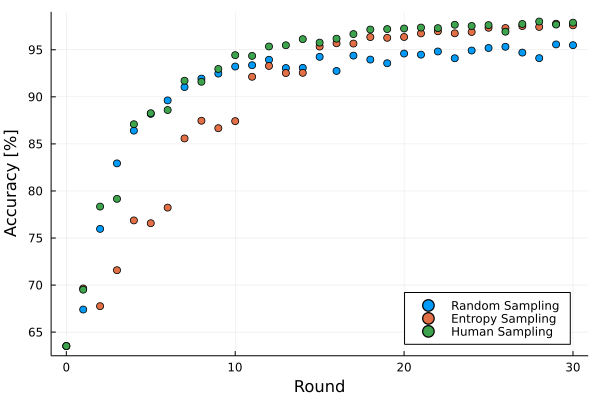

In [11]:
# TODO Run 30 runs to get error bars.
scatter(rounds_random, 100 .* accuracies_random, label="Random Sampling",
    legend_position=:bottomright, xlabel="Round", ylabel="Accuracy [%]")
scatter!(rounds_entropy, 100 .* accuracies_entropy, label="Entropy Sampling")
scatter!(rounds_human, 100 .* accuracies_human, label="Human Sampling")